# Explore network traffic dump

We will explore a network traffic trace file and perform some initial analysis.

You will need  following tools:
    
* **Pandas**, a Python library for analysing data <http://pandas.pydata.org/>
* **tshark**, the command line version of the Wireshark sniffer <http://http://www.wireshark.org/>
* **Matplotlib**, a Python plotting library <http://matplotlib.org/>

## Download the traffic trace file

First, download the traffic trace file "traffic_dump.pcap", and this IPython notebook "Network Traffic Exploration.ipynb" from Blackboard, and save them into the same directory.

In [ ]:
!ls -l

## Convert PCAP to a CSV using tshark

We can use the `tshark` command from the Wireshark tool suite to read the PCAP file and convert it into a tab-separated file. This might not be very fast, but it is very flexible, because all of Wireshark's diplay filters can be used to select the packets that we are interested in.

In [1]:
!tshark --help

TShark (Wireshark) 2.0.2 (v2.0.2-0-ga16e22e from master-2.0)
Dump and analyze network traffic.
See https://www.wireshark.org for more information.

Usage: tshark [options] ...

Capture interface:
  -i <interface>           name or idx of interface (def: first non-loopback)
  -f <capture filter>      packet filter in libpcap filter syntax
  -s <snaplen>             packet snapshot length (def: 65535)
  -p                       don't capture in promiscuous mode
  -B <buffer size>         size of kernel buffer (def: 2MB)
  -y <link type>           link layer type (def: first appropriate)
  -D                       print list of interfaces and exit
  -L                       print list of link-layer types of iface and exit

Capture stop conditions:
  -c <packet count>        stop after n packets (def: infinite)
  -a <autostop cond.> ...  duration:NUM - stop after NUM seconds
                           filesize:NUM - stop this file after NUM KB
                              files:NUM - stop

Let's read the traffic_dump.pcap into tshark, and display frame number and frame length of each captured packet.
* -n: no name resolution
* -r: read from file, not a live capture
* -T fields: use table fields as the output format
* -T header=y: display header
* -e: field to display

In [2]:
!tshark -n -r traffic_dump.pcap -T fields -Eheader=y -e frame.number -e frame.len > frame.len

Let's have a look at the file:

In [3]:
!head -10 frame.len

'head' is not recognized as an internal or external command,
operable program or batch file.


Use Pandas to read the table into a DataFrame object:

In [4]:
import pandas as pd

In [5]:
df=pd.read_table("frame.len")

Take a look of the data frame.

In [6]:
df

,frame.number,frame.len
0,1,70
1,2,70
2,3,1421
3,4,70
4,5,1284
5,6,70
6,7,70
7,8,70
8,9,78
9,10,78


Some statistics about the frame length:

In [18]:
df["frame.len"].describe()

count    94410.000000
mean       579.072524
std        625.671800
min         42.000000
25%         70.000000
50%         86.000000
75%       1466.000000
max       1466.000000
Name: frame.len, dtype: float64

The min and max are compliant with Ethernet specifications.

## Plotting

For a better overview, we plot the frame length over time.

We initialise IPython to show inline graphics:

In [8]:
#import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set a figure size in inches:

In [9]:
figsize(10,6)

Pandas automatically uses Matplotlib for plotting. We plot with small dots and an alpha channel of 0.2:

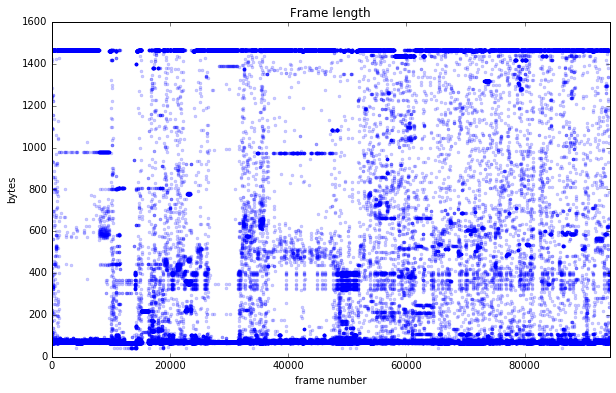

In [10]:
df["frame.len"].plot(style=".", alpha=0.2)
title("Frame length")
ylabel("bytes")
xlabel("frame number")

So there are always lots of small packets (< 100 bytes) and lots of large packets (> 1400 bytes). Some bursts of packets with other sizes (around 400 bytes, 1000 bytes, etc.) can be clearly seen.

### A nice Python function to help read data

Here is a convenient helper function that reads the given fields into a Pandas DataFrame:

In [20]:
import subprocess
import datetime
import pandas as pd

def read_traffic(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else []
    if display_filter:
        display_filters.append(display_filter)
    filterspec = "-Y '%s'" % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    print cmd
    proc = subprocess.Popen(cmd, shell = True, 
                                 stdout=subprocess.PIPE)
    if timeseries:
        df = pd.read_table(proc.stdout, 
                        index_col = "frame.time_epoch", 
                        parse_dates=True, 
                        date_parser=datetime.datetime.fromtimestamp)
    else:
        df = pd.read_table(proc.stdout)
    return df

## Bandwidth Usage

We want to know how much bandwidth is used every second. To do that, we need to sum up the frame lengths for every second.

First use our helper function to read the traffic trace into a DataFrame:

In [21]:
framelen=read_traffic("traffic_dump.pcap", ["frame.len"], timeseries=True)
framelen
tshark -r traffic_dump.pcap -n -Eheader=y -Y '' -e frame.time_epoch -e frame.len -T fields

tshark -r traffic_dump.pcap -n -T fields -Eheader=y -Y '' -e frame.time_epoch -e frame.len


EmptyDataError: No columns to parse from file

Then we re-sample the timeseries into buckets of 1 second, summing over the lengths of all frames that were captured in that second:

In [15]:
#bytes_per_second=framelen.resample("S", how="sum")
bytes_per_second=framelen.resample("S").sum()

NameError: name 'framelen' is not defined

Here are the first 5 rows. We get NaN for those timestamps where no frames were captured:

In [35]:
bytes_per_second.head()

In [36]:
bytes_per_second.plot()

## Analyze the trace at TCP level

Let's try to replicate the TCP Time-Sequence Graph

In [37]:
fields=["tcp.stream", "ip.src", "ip.dst", "tcp.seq", "tcp.ack", "tcp.window_size", "tcp.len"]
ts=read_traffic("traffic_dump.pcap", fields, timeseries=True, strict=True)
ts

Now we have to select a TCP stream to analyse. As an example, we just pick stream number 10:

In [38]:
stream=ts[ts["tcp.stream"] == 10]
stream

Add a column that shows who sent the packet (client or server). 

The fancy lambda expression is a function that distinguishes between the client and the server side of the stream by comparing the source IP address with the source IP address of the first packet in the stream (for TCP steams that should have been sent by the client).

In [39]:
stream["type"] = stream.apply(lambda x: "client" if x["ip.src"] == stream.iloc[0]["ip.src"] else "server", axis=1)

In [49]:
#print stream.to_string()
stream

In [41]:
client_stream=stream[stream.type == "client"]
client_stream

In [42]:
client_stream["tcp.seq"].plot(style="r-o")

Notice that the x-axis shows the real timestamps.

For comparison, change the x-axis to be the packet number in the stream:

In [43]:
client_stream.index = arange(len(client_stream))
client_stream["tcp.seq"].plot(style="r-o")

Looks different of course.

## Bytes per stream

In [44]:
per_stream=ts.groupby("tcp.stream")
per_stream.head()

In [46]:
bytes_per_stream = per_stream["tcp.len"].sum()
bytes_per_stream.head()

In [47]:
bytes_per_stream.plot()

In [46]:
bytes_per_stream.max()

In [47]:
biggest_stream=bytes_per_stream.idxmax()
biggest_stream

In [36]:
bytes_per_stream.ix[biggest_stream]

# Your turn

## Task 1: Query function
Write a function, given an ip address, output information of all TCP streams that involve this ip address, including stream's starting time, ending time, the other ip address, and stream's size in packets

## Task 2: Plot the query results
Plot the obtained information in task 1 as a time series on streams' starting times. Use multiple plots for different information. For exmaple, one plot for the other ip address, and one plot for stream size.

## Task 3: Restore the content of streams
Use the tool tcpflow (http://www.forensicswiki.org/wiki/Tcpflow) to save all stream content to external files. 